In [143]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision


In [144]:
dtype = torch.float
device = torch.device('cuda')
print(device)

cuda


In [145]:
root = os.path.expanduser('~/data/datasets/torch/mnist')
train_dataset = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=True)

In [146]:
# flatten and normalize
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0], -1) / 255

x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0], -1) / 255

y_train = np.array(train_dataset.targets, dtype=np.long)
y_test = np.array(test_dataset.targets, dtype=np.long)

del train_dataset, test_dataset

(-0.5, 27.5, 27.5, -0.5)

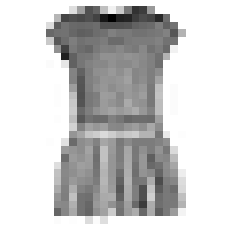

In [147]:
plt.imshow(x_train[15].reshape(28, 28), cmap=plt.cm.gray_r)
plt.axis('off')

In [ ]:
num_inputs, num_hidden, num_outputs = 28 * 28, 100, 10

time_step, num_steps = 1e-3, 100

batch_size = 256


In [148]:
def current_to_firing_time(x, tau=20, firing_threshold=0.2, time_max = 1.0, epsilon=1e-7):
    """

    :param x: data
    :param tau: time constant of the membrane in LIF neuron model
    :param firing_threshold: firing threshold value
    :param time_max: maximum time to be returned
    :param epsilon: generic epsilon > 0
    :return: time to first spike for each "current" x
    """
    index = x < firing_threshold
    x = np.clip(x, firing_threshold + epsilon, 1e9)
    times_for_first_spike = tau * np.log(x / (x - firing_threshold))
    times_for_first_spike[index] = time_max
    return times_for_first_spike

def sparse_data_generator(features, labels, batch_size, nb_steps, nb_units, shuffle=True):
    """
    Generates spiking network input from standard analog input
    :param features: features - num_samples x given_event x (time, neuron)
    :param labels: labels
    """

    labels = np.array(labels, dtype=np.long)
    num_of_batches = len(features) // batch_size
    sample_index = np.arange(len(features))

    tau_eff = 20e-3 / time_step

    firing_times = current_to_firing_time(features, tau=tau_eff, time_max=nb_steps)
    firing_times = np.array(firing_times, dtype=np.long)

    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    counter, total_batch_count = 0, 0
    while counter < num_of_batches:
        batch_index = sample_index[batch_size*counter : batch_size*(counter+1)]

        data = [ [] for _ in range(3)]

        for bc, idx in enumerate(batch_index):
            c = firing_times[idx] < nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            data[0].extend(batch)
            data[1].extend(times)
            data[2].extend(units)

        i = torch.LongTensor(data).to(device)
        v = torch.FloatTensor(np.ones(len(data[0]))).to(device)

        x_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps, nb_units])).to(device)
        y_batch = torch.tensor(labels[batch_index], device=device, dtype=torch.long) # chybel dtype

        yield x_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [149]:
# Spiking network setup

tau_membrane, tau_synapse = 10e-3, 5e-3
alpha, beta = float(np.exp(-time_step/tau_synapse)), float(np.exp(-time_step/tau_membrane))

In [150]:
weight_scale = 7 * (1.0 - beta)

w1 = torch.empty((num_inputs, num_hidden), device=device, dtype=dtype, requires_grad=True)
w2 = torch.empty((num_hidden, num_outputs), device=device, dtype=dtype, requires_grad=True)

torch.nn.init.normal(w2, mean=0.0, std=weight_scale / np.sqrt(num_hidden))

print('initialized')

initialized


<ipython-input-150-110c50862c3a>:6: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(w2, mean=0.0, std=weight_scale / np.sqrt(num_hidden))


In [151]:
class SurrGradSpike(torch.autograd.Function):

    scale = 100.0

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input = ctx.saved_tensors # ,
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0) ** 2
        return grad

spike_fn = SurrGradSpike.apply

In [152]:
def run_snn(inputs):
    h1 = torch.einsum('abc,cd->abd', (inputs, w1))
    synapse = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    membrane = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)

    mem_recordings = [membrane]
    spike_recordings = [membrane]

    for dt in range(num_steps):
        membrane_threshold = membrane - 1.0
        out = spike_fn(membrane_threshold)
        rst = torch.zeros_like(membrane)
        c = (membrane_threshold > 0)
        rst[c] = torch.ones_like(membrane)[c]

        new_synapse = alpha * synapse + h1[:, dt]
        new_membrane = beta * membrane - rst

        membrane, synapse = new_membrane, new_synapse
        mem_recordings.append(membrane)
        spike_recordings.append(out)

    mem_recordings = torch.stack(mem_recordings, dim=1)
    spike_recordings = torch.stack(spike_recordings, dim=1)

    h2 = torch.einsum('abc,cd->abd', (spike_recordings, w2))
    flt = torch.zeros((batch_size, num_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size, num_outputs), device=device, dtype=dtype)
    out_recordings = [out]

    for dt in range(num_steps):
        new_flt = alpha * flt + h2[:, dt]
        new_out = beta * out + flt

        flt, out = new_flt, new_out
        out_recordings.append(out)

    out_recordings = torch.stack(out_recordings, dim=1) # output layer results
    other_recordings = [mem_recordings, spike_recordings] # spikes and membrane recordings for visualization

    return out_recordings, other_recordings

In [153]:
def train(x_data, y_data, lr=2e-3, num_epochs=10):
    params = [w1, w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    loss_hist = []
    for epoch in range(num_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(features=x_data, labels=y_data, batch_size=batch_size,
                                                      nb_steps=num_steps, nb_units=num_inputs, time_step=time_step):
            output, _ = run_snn(inputs=x_local.to_dense())
            m, _ = torch.max(output, 1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())

        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(epoch+1,mean_loss))
        loss_hist.append(mean_loss)

def get_accuracy(x_data, y_data):
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, num_steps, num_inputs, False, time_step):
        output = run_snn(x_local.to_dense())
        m, _ = torch.max(output, 1)
        _, am = torch.max(m, 1)
        accs.append(np.mean((y_local == am).detach().cpu().numpy()))
    return np.mean(accs)

In [154]:
loss_hist = train(x_train, y_train, lr=2e-4, num_epochs=30)

Epoch 1: loss=2.30258


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [ ]:
print("Training accuracy: %.3f"%(get_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(get_accuracy(x_test,y_test)))